# Bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve

sns.set_style('dark')

# Bases de Dados

In [5]:
# Exemplo de criação de uma base de dados desbalanceada
X, y = make_classification(
    n_samples = 100000,  
    n_features = 10, 
    n_informative = 10, 
    n_redundant = 0,
    n_classes = 2, 
    weights = [0.99, 0.01],
    flip_y = 0,
    random_state = 42
)

# Transforma o output anterior em um DataFrame
df = pd.DataFrame(X, columns = [f"X_{i}" for i in range(X.shape[1])])
df['y'] = y

df['y'].value_counts()

y
0    99000
1     1000
Name: count, dtype: int64

# [Simulação] Perda de Performance conforme o desbalanceamento da base aumenta

In [6]:
from scipy.stats import ks_2samp

# Vamos gerar bases de dados desbalanceadas de 50% até 1% de desbalanceamento
prop_list = [round(x, 2) for x in np.arange(0.5, 0.001, -0.01)]
metricas = pd.DataFrame()

for prop in prop_list:
    
    X, y = make_classification(
        n_samples = 100000,  
        n_features = 10, 
        n_informative = 10, 
        n_redundant = 0,
        n_classes = 2, 
        weights = [1 - prop, prop],
        flip_y = 0.01,
        random_state = 42
    )
    
    # Separa o conjunto em base de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.3,
        random_state = 42
    )
    
    lr = LogisticRegression(
        penalty = None,
        random_state = 42
    )   
    
    lr.fit(X_train, y_train)
    
    # Otimização do melhor ponto de corte
    y_probs = lr.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Métricas & Previsão
    y_pred = [1 if x >= optimal_threshold else 0 for x in y_probs]
    
    # Cálculo do KS
    ks_stat, _ = ks_2samp(y_probs[y_test == 0], y_probs[y_test == 1])
    
    performance = pd.DataFrame(
        {
            "Proporção" : [prop],
            "Acurácia" :[accuracy_score(y_test, y_pred)],
            "Acurácia Balanceada" : [balanced_accuracy_score(y_test, y_pred)],
            "Precisão" : [precision_score(y_test, y_pred)],
            "Recall" : [recall_score(y_test, y_pred)],
            "F1 Score" : [f1_score(y_test, y_pred)],
            "ROC AUC Score" : [roc_auc_score(y_test, y_pred)],
            "Optimal Threshold" : [optimal_threshold],
            "KS" : [ks_stat]
        }
    )

    metricas = pd.concat([metricas, performance], ignore_index = True)
    
metricas.head()

,Proporção,Acurácia,Acurácia Balanceada,Precisão,Recall,F1 Score,ROC AUC Score,Optimal Threshold,KS
0,0.50,0.848333,0.848320,0.847994,0.850806,0.849398,0.848320,0.492553,0.696640
1,0.49,0.847933,0.847995,0.841166,0.851987,0.846542,0.847995,0.478769,0.695990
2,0.48,0.847867,0.847975,0.836345,0.851030,0.843624,0.847975,0.470332,0.695951
3,0.47,0.847433,0.847553,0.831449,0.849785,0.840517,0.847553,0.461239,0.695107
4,0.46,0.847433,0.847596,0.826005,0.849827,0.837747,0.847596,0.450254,0.695193


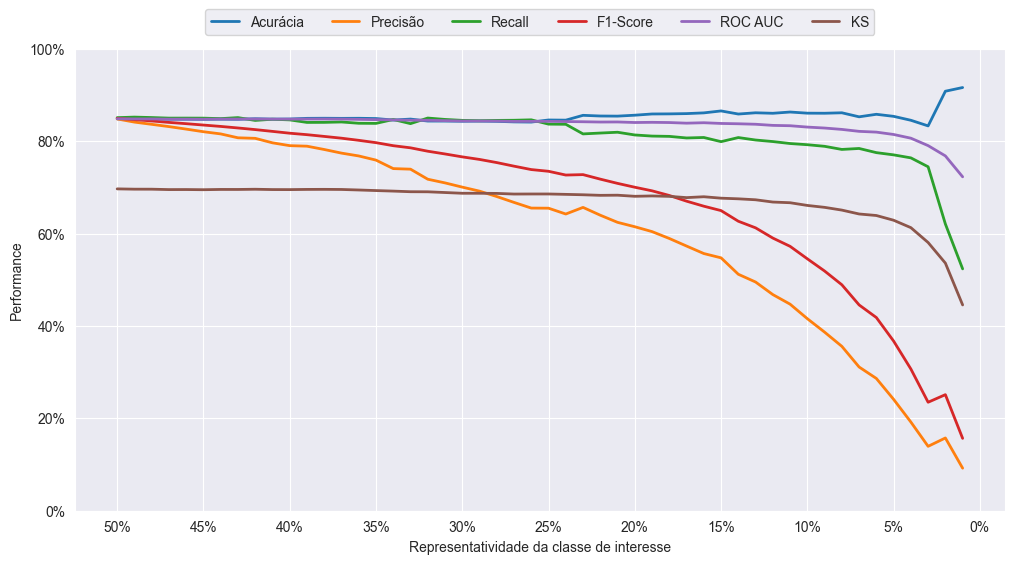

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(
    metricas['Proporção'],
    metricas['Acurácia'],
    linewidth=2,
    label='Acurácia'
)
plt.plot(
    metricas['Proporção'],
    metricas['Precisão'],
    linewidth=2,
    label='Precisão'
)
plt.plot(
    metricas['Proporção'],
    metricas['Recall'],
    linewidth=2,
    label='Recall'
)
plt.plot(
    metricas['Proporção'],
    metricas['F1 Score'],
    linewidth=2,
    label='F1-Score'
)
plt.plot(
    metricas['Proporção'],
    metricas['ROC AUC Score'],
    linewidth=2,
    label='ROC AUC'
)
plt.plot(
    metricas['Proporção'],
    metricas['KS'],
    linewidth=2,
    label='KS'
)

plt.gca().invert_xaxis()

# Eixo Y
plt.yticks(
    np.arange(0, 1.1, 0.2),
    [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.2)]
)
plt.ylim(0, 1)

# Eixo X
plt.xticks(
    np.linspace(0.5, 0, 11),
    [f'{int(np.ceil(i*100))}%' for i in np.linspace(0.5, 0, 11)]
)

plt.xlabel("Representatividade da classe de interesse")
plt.ylabel("Performance")

plt.legend(
    loc='upper center',
    ncol=10,
    bbox_to_anchor=(0.5, 1.1)
)
plt.grid()
plt.plot()

plt.show()


In [9]:
from scipy.stats import ks_2samp

# Vamos gerar bases de dados desbalanceadas de 50% até 1% de desbalanceamento
prop_list = [round(x, 3) for x in np.arange(0.01, 0.0001, -0.001)]
metricas_caso_extremo = pd.DataFrame()

for prop in prop_list:
    print(prop) 
    
    X, y = make_classification(
        n_samples = 100000,  
        n_features = 10, 
        n_informative = 10, 
        n_redundant = 0,
        n_classes = 2, 
        flip_y = 0.01,
        weights = [1 - prop, prop],
        random_state = 42
    )
    
    # Separa o conjunto em base de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.3,
        random_state = 42
    )
    
    lr = LogisticRegression(
        penalty = None,
        random_state = 42
    )   
    
    lr.fit(X_train, y_train)
    
    # Otimização do melhor ponto de corte
    y_probs = lr.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Métricas & Previsão
    y_pred = [1 if x >= optimal_threshold else 0 for x in y_probs]
    
    # Cálculo do KS
    ks_stat, _ = ks_2samp(y_probs[y_test == 0], y_probs[y_test == 1])
    
    performance = pd.DataFrame(
        {
            "Proporção" : [prop],
            "Acurácia" :[ accuracy_score(y_test, y_pred)],
            "Acurácia Balanceada" : [balanced_accuracy_score(y_test, y_pred)],
            "Precisão" : [precision_score(y_test, y_pred)],
            "Recall" : [recall_score(y_test, y_pred)],
            "F1 Score" : [f1_score(y_test, y_pred)],
            "ROC AUC Score" : [roc_auc_score(y_test, y_pred)],
            "Optimal Threshold" : [optimal_threshold],
            "KS" : [ks_stat]
        }
    )

    metricas_caso_extremo = pd.concat([metricas_caso_extremo, performance], ignore_index = True)

0.01
0.009
0.008
0.007
0.006
0.005
0.004
0.003
0.002
0.001


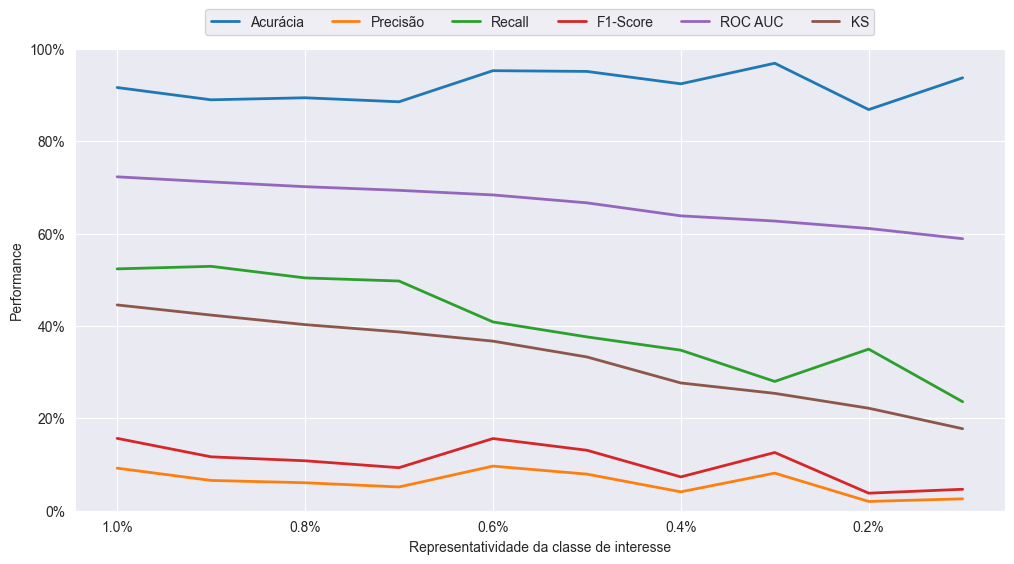

In [20]:
plt.figure(figsize=(12, 6))

plt.plot(
    metricas_caso_extremo['Proporção'],
    metricas_caso_extremo['Acurácia'],
    linewidth=2,
    label='Acurácia'
)
plt.plot(
    metricas_caso_extremo['Proporção'],
    metricas_caso_extremo['Precisão'],
    linewidth=2,
    label='Precisão'
)
plt.plot(
    metricas_caso_extremo['Proporção'],
    metricas_caso_extremo['Recall'],
    linewidth=2,
    label='Recall'
)
plt.plot(
    metricas_caso_extremo['Proporção'],
    metricas_caso_extremo['F1 Score'],
    linewidth=2,
    label='F1-Score'
)
plt.plot(
    metricas_caso_extremo['Proporção'],
    metricas_caso_extremo['ROC AUC Score'],
    linewidth=2,
    label='ROC AUC'
)
plt.plot(
    metricas_caso_extremo['Proporção'],
    metricas_caso_extremo['KS'],
    linewidth=2,
    label='KS'
)

plt.gca().invert_xaxis()

# Eixo Y
plt.yticks(
    np.arange(0, 1.1, 0.2),
    [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.2)]
)
plt.ylim(0, 1)

# Eixo X
plt.xticks(
    np.linspace(0.01, 0, 6),
    [f'{i*100}%' for i in np.linspace(0.01, 0, 6)]
)

plt.xlabel("Representatividade da classe de interesse")
plt.ylabel("Performance")

plt.legend(
    loc='upper center',
    ncol=10,
    bbox_to_anchor=(0.5, 1.1)
)
plt.grid()
plt.plot()

plt.show()


# Apenas balancear o algoritmo pode resolver o problema?

In [ ]:
X, y = make_classification(
    n_samples = 10000,  
    n_features = 10, 
    n_informative = 10, 
    n_redundant=0,
    n_classes = 2, 
    flip_y = 0.01,
    weights = [1-prop],
    random_state = 42
)

In [128]:
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# Vamos gerar bases de dados desbalanceadas de 50% até 1% de desbalanceamento
prop_list = [0.05, 0.04, 0.03, 0.02, 0.01]
metricas_classico = pd.DataFrame()
metricas_balanceado = pd.DataFrame()

for prop in prop_list:
    
    X, y = make_classification(
        n_samples = 100000,  
        n_features = 10, 
        n_informative = 10, 
        n_redundant=0,
        n_classes = 2, 
        flip_y = 0.005,
        weights = [1-prop],
        class_sep = 0.9,
        random_state = 42
    )
    
    # Separa o conjunto em base de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.3,
        random_state = 42
    )
    
    max_strategy = sum(y_train == 1) / sum(y_train == 0)
    sampling_strategies = np.linspace(1, max_strategy, 20)[:-1]

    
    # XGBoost clássico
    lr = AdaBoostClassifier(random_state=42)
    lr.fit(X_train, y_train)
    
    
    
    # XGBoost com undersampling
    best_f1_score = 0
    best_strategy = None
    
    for strategy in sampling_strategies:
        rus = RandomUnderSampler(
            random_state=42,
            sampling_strategy=strategy
        )
        
        X_res, y_res = rus.fit_resample(X_train, y_train)
        
        lr_balanced = AdaBoostClassifier(random_state=42)
        lr_balanced.fit(X_res, y_res)
        
        # Otimização do melhor ponto de corte
        y_probs_balanced = lr_balanced.predict_proba(X_test)[:, 1]
        fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test, y_probs_balanced)
        optimal_idx_balanced = np.argmax(tpr_balanced - fpr_balanced)
        optimal_threshold_balanced = thresholds_balanced[optimal_idx_balanced]
        y_pred_balanced = [1 if x >= optimal_threshold_balanced else 0 for x in y_probs_balanced]
        
        # Métricas
        f1 = f1_score(y_test, y_pred_balanced)
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_strategy = strategy
    
    # Treina o modelo com a melhor estratégia
    rus = RandomUnderSampler(
        random_state=42,
        sampling_strategy=best_strategy
    )
    
    X_res, y_res = rus.fit_resample(X_train, y_train)
    
    lr_balanced = AdaBoostClassifier(random_state=42)
    lr_balanced.fit(X_res, y_res)
    
    # Otimização do melhor ponto de corte para o XGBoost clássico
    y_probs = lr.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred = [1 if x >= optimal_threshold else 0 for x in y_probs]
    
    
    # Métricas para o XGBoost clássico
    performance = pd.DataFrame(
        {
            "Proporção" : [prop],
            "Acurácia" :[accuracy_score(y_test, y_pred)],
            "Acurácia Balanceada" : [balanced_accuracy_score(y_test, y_pred)],
            "Precisão" : [precision_score(y_test, y_pred)],
            "Recall" : [recall_score(y_test, y_pred)],
            "F1 Score" : [f1_score(y_test, y_pred)],
            "ROC AUC Score" : [roc_auc_score(y_test, y_pred)],
            "Optimal Threshold" : [optimal_threshold]
        }
    )
    ks_stat = max(tpr - fpr)
    performance["KS"] = [ks_stat]
    
    # Otimização do melhor ponto de corte para o XGBoost com undersampling
    y_probs_balanced = lr_balanced.predict_proba(X_test)[:, 1]
    fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test, y_probs_balanced)
    optimal_idx_balanced = np.argmax(tpr_balanced - fpr_balanced)
    optimal_threshold_balanced = thresholds_balanced[optimal_idx_balanced]
    y_pred_balanced = [1 if x >= optimal_threshold_balanced else 0 for x in y_probs_balanced]
    
    # Métricas para o XGBoost com undersampling
    ks_stat_balanced = max(tpr_balanced - fpr_balanced)    
        
    performance_balanced = pd.DataFrame(
        {
            "Proporção" : [prop],
            "Acurácia" :[accuracy_score(y_test, y_pred_balanced)],
            "Acurácia Balanceada" : [balanced_accuracy_score(y_test, y_pred_balanced)],
            "Precisão" : [precision_score(y_test, y_pred_balanced)],
            "Recall" : [recall_score(y_test, y_pred_balanced)],
            "F1 Score" : [f1_score(y_test, y_pred_balanced)],
            "ROC AUC Score" : [roc_auc_score(y_test, y_pred_balanced)],
            "KS" : [ks_stat_balanced],
            "Optimal Threshold" : [optimal_threshold_balanced]
        }
    )
    
    metricas_classico = pd.concat([metricas_classico, performance], ignore_index = True)
    metricas_balanceado = pd.concat([metricas_balanceado, performance_balanced], ignore_index = True)


c:\Users\zheag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zheag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zheag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zheag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is 

In [129]:
metricas_classico

,Proporção,Acurácia,Acurácia Balanceada,Precisão,Recall,F1 Score,ROC AUC Score,Optimal Threshold,KS
0,0.05,0.832233,0.815806,0.214751,0.797398,0.338373,0.815806,0.485450,0.631612
1,0.04,0.825367,0.810478,0.175523,0.794140,0.287502,0.810478,0.484185,0.620956
2,0.03,0.876533,0.799092,0.177435,0.715953,0.284389,0.799092,0.485041,0.598184
3,0.02,0.823167,0.785417,0.093899,0.745787,0.166798,0.785417,0.481161,0.570834
4,0.01,0.873333,0.755471,0.068234,0.634204,0.123212,0.755471,0.480088,0.510941


In [130]:
metricas_balanceado

,Proporção,Acurácia,Acurácia Balanceada,Precisão,Recall,F1 Score,ROC AUC Score,KS,Optimal Threshold
0,0.05,0.873167,0.816400,0.262930,0.752788,0.389735,0.816400,0.632799,0.501216
1,0.04,0.872567,0.814039,0.222371,0.749812,0.343014,0.814039,0.628078,0.501720
2,0.03,0.895800,0.793117,0.200457,0.682879,0.309934,0.793117,0.586234,0.500445
3,0.02,0.901367,0.785042,0.147916,0.662921,0.241865,0.785042,0.570085,0.503615
4,0.01,0.919633,0.753194,0.098790,0.581948,0.168907,0.753194,0.506387,0.495532


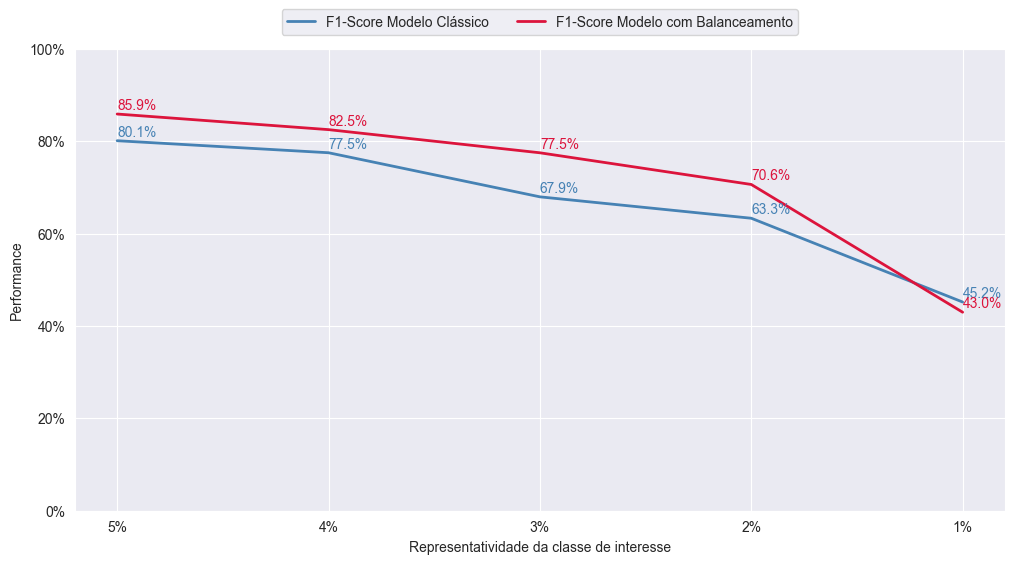

In [73]:
plt.figure(figsize=(12, 6))

# Plot para o modelo clássico
plt.plot(
    metricas_classico['Proporção'],
    metricas_classico['F1 Score'],
    linewidth=2,
    label='F1-Score Modelo Clássico',
    color='steelblue'
)

# Adiciona rótulos para o modelo clássico
for i, txt in enumerate(metricas_classico['F1 Score']):
    plt.annotate(f'{txt:.1%}', (metricas_classico['Proporção'][i], metricas_classico['F1 Score'][i]+0.01), color='steelblue')

# Plot para o modelo com balanceamento
plt.plot(
    metricas_balanceado['Proporção'],
    metricas_balanceado['F1 Score'],
    linewidth=2,
    label='F1-Score Modelo com Balanceamento',
    color='crimson'
)

# Adiciona rótulos para o modelo com balanceamento
for i, txt in enumerate(metricas_balanceado['F1 Score']):
    plt.annotate(f'{txt:.1%}', (metricas_balanceado['Proporção'][i], metricas_balanceado['F1 Score'][i]+0.01), color='crimson')

plt.gca().invert_xaxis()

# Eixo Y
plt.yticks(
    np.arange(0, 1.1, 0.2),
    [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.2)]
)
plt.ylim(0, 1)

# Eixo X
plt.xticks(
    np.linspace(0.05, 0, 6),
    [f'{int(i*100)}%' for i in np.linspace(0.05, 0, 6)]
)
plt.xlabel("Representatividade da classe de interesse")
plt.ylabel("Performance")

plt.legend(
    loc='upper center',
    ncol=10,
    bbox_to_anchor=(0.5, 1.1)
)
plt.grid()
plt.plot()

plt.show()

